# LSTM: Sectionals_v1

Train an LSTM to analyze a horse’s past performance sequence and predict the horse's race pattern that reflects its projected strength today.

✅ This model, unless it proves predictive on a standalone apactity, will be fed into the CatBoost/YetiRank model as a feature.

⸻

🔍 How Accurate is Ranking by Sectional Data Alone?

🔥 The Good:

If your LSTM is trained on well-normalized, consistent historical speed signals: • Relative ordering can be quite meaningful • Especially in smaller fields or when you’re identifying top 3–4 finishers • Even if absolute values are off, ranking is often more robust

❄️ The Limitations: • LSTM alone won’t account for today’s track conditions, surface bias, jockey/trainer changes, distance, class jump/drop • It may favor horses that ran fast recently but are now outclassed or mispositioned

In [1]:
# Setup Environment
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import optuna
import torch.nn as nn
import numpy as np
import optuna.visualization as viz
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import (to_date, date_format, lpad, concat_ws, collect_list, struct, 
                                   col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql

In [3]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [4]:
# def gps_sql_queries():
#     queries = {
#         "gps_horse": """
#             SELECT g.course_cd, g.race_date,g.race_number,
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, time_stamp, 
#             longitude, latitude, speed, progress, stride_frequency, g.post_time, location,
#             re.axciskey, h.horse_id, re.official_fin, h.horse_name
#             FROM gpspoint g
#             JOIN results_entries re on g.course_cd = re.course_cd
#                 AND g.race_date = re.race_date
#                 AND g.race_number = re.race_number
#                 AND g.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey
#             WHERE speed is not null
#             AND progress is not null
#             AND stride_frequency is not null
#             """,
#         "sectionals": """
#             SELECT s.course_cd, s.race_date, s.race_number, h.horse_id, 
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, 
#             s.gate_name, s.gate_numeric, s.length_to_finish, s.sectional_time, s.running_time, 
#             s.distance_back, s.distance_ran, s.number_of_strides, s.post_time, re.official_fin
#             FROM sectionals s
#             JOIN results_entries re on s.course_cd = re.course_cd
#                 AND s.race_date = re.race_date
#                 AND s.race_number = re.race_number
#                 AND s.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey 
#             WHERE length_to_finish is not null
#             AND sectional_time is not null
#             AND running_time is not null
#             AND distance_back is not null
#             AND distance_ran is not null
#             AND distance_ran is not null
#             AND number_of_strides is not null
#             """
#     }
#     return queries


In [5]:
# queries = gps_sql_queries()
# dfs = load_data_from_postgresql(spark, jdbc_url, jdbc_properties, queries, parquet_dir)
#         # Suppose we have a dictionary of queries
# for name, df in dfs.items():
#     logging.info(f"DataFrame '{name}' loaded. Schema:")
#     df.printSchema()
#     if name == "gps_horse":
#         gps_horse_df = df
#     elif name == "sectionals":
#         sectionals_df = df    
#     else:
#         logging.error(f"Unknown DataFrame name: {name}")
#         continue


In [6]:

# start_time = time.time()
# # gps_horse_df.write.mode("overwrite").parquet(f"{parquet_dir}/gps_horse_df")
# sectionals_df.write.mode("overwrite").parquet(f"{parquet_dir}/sectionals_df")
# logging.info(f"Data written to Parquet in {time.time() - start_time:.2f} seconds")
    

In [7]:
# gps_horse_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/gps_horse_df")
sectionals_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/sectionals_df")


In [8]:
# Convert race_date to a proper date format
sectionals_df = sectionals_df.withColumn("race_date", to_date(col("race_date")))

# Construct a unique race_id using course_cd, race_date, and race_number
sectionals_df = sectionals_df.withColumn(
    "race_id",
    concat_ws(
        "_",
        col("course_cd"),
        date_format(col("race_date"), "yyyyMMdd"),
        lpad(col("race_number").cast("string"), 2, "0")
    )
)


## Create gate_seq_num Column

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Filter out finish rows to compute max gate_numeric per race
non_finish_df = sectionals_df.filter(F.col("gate_name") != "finish")

# Define a window partitioning by race identifiers
race_window = Window.partitionBy("course_cd", "race_date", "race_number")

# Compute maximum gate_numeric for each race (ignoring finish rows)
max_gate_df = non_finish_df.groupBy("course_cd", "race_date", "race_number") \
    .agg(F.max("gate_numeric").alias("max_gate_numeric"))

# Step 2: Join the maximum gate value back to the original DataFrame
joined_df = sectionals_df.join(max_gate_df, on=["course_cd", "race_date", "race_number"], how="left")

# Step 3: Create the new column 'gate_seq_num'
# If the gate is 'finish', assign max_gate_numeric + 0.5, else keep gate_numeric.
sectionals_df = joined_df.withColumn(
    "gate_seq_num",
    F.when(F.col("gate_name") == "finish", F.col("max_gate_numeric") + F.lit(0.5))
     .otherwise(F.col("gate_numeric"))
)

# Optionally, display the results for a single race
sectionals_df.select("saddle_cloth_number", "race_id", "gate_name", "gate_numeric", "gate_seq_num").show(15, truncate=False)

+-------------------+---------------+---------+------------+------------+
|saddle_cloth_number|race_id        |gate_name|gate_numeric|gate_seq_num|
+-------------------+---------------+---------+------------+------------+
|6                  |TKD_20220908_02|0.5f     |0.5         |0.5         |
|6                  |TKD_20220908_02|1.5f     |1.5         |1.5         |
|6                  |TKD_20220908_02|1f       |1.0         |1.0         |
|6                  |TKD_20220908_02|2.5f     |2.5         |2.5         |
|6                  |TKD_20220908_02|2f       |2.0         |2.0         |
|6                  |TKD_20220908_02|3.5f     |3.5         |3.5         |
|6                  |TKD_20220908_02|3f       |3.0         |3.0         |
|6                  |TKD_20220908_02|4.5f     |4.5         |4.5         |
|6                  |TKD_20220908_02|4f       |4.0         |4.0         |
|6                  |TKD_20220908_02|5.5f     |5.5         |5.5         |
|6                  |TKD_20220908_02|5

## Sort

In [10]:

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("race_id", "horse_id").orderBy(F.asc("gate_seq_num"))
sectionals_df = sectionals_df.withColumn("segment_ordinal", row_number().over(window_spec))


In [11]:
sectionals_df.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- race_id: string (nullable = false)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- segment_ordinal: integer (nullable = false)



## Assign Target/Relevance:

In [12]:
from pyspark.sql import functions as F

def assign_piecewise_log_labels_spark(df, alpha=30.0, beta=4.0):
    df_out = df.withColumn(
        "relevance",
        F.when(F.col("official_fin") == 1, 70.0)
         .when(F.col("official_fin") == 2, 56.0)
         .when(F.col("official_fin") == 3, 44.0)
         .when(F.col("official_fin") == 4, 34.0)
         .otherwise(F.lit(alpha) / F.log(F.lit(beta) + F.col("official_fin")))
    ).withColumn(
        "top4_label",
        F.when(F.col("official_fin") <= 4, F.lit(1)).otherwise(F.lit(0))
    )
    return df_out

In [13]:
sectionals_df = assign_piecewise_log_labels_spark(sectionals_df)

In [14]:
sectionals_df.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- race_id: string (nullable = false)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- segment_ordinal: integer (nullable = false)
 |-- relevance: double (nullable = true)
 |-- top4_label: integer (nullable = false)



# Compute Sequence Lenghts

### Drop Rows with >=10 and <=18 Sequences

In [17]:

# Step 1: Compute sequence lengths per horse per race
df_seq_len = sectionals_df.groupBy("race_id", "horse_id").agg(F.count("*").alias("seq_length"))

# Step 2: Filter sequences with length between 10 and 18
filtered_df = df_seq_len.filter((F.col("seq_length") >= 10) & (F.col("seq_length") <= 18))

# Step 3: Join the filtered sequence lengths back with the original data
sectionals_df = sectionals_df.join(filtered_df, on=["race_id", "horse_id"], how="inner")

### Plot Sequence Lengths

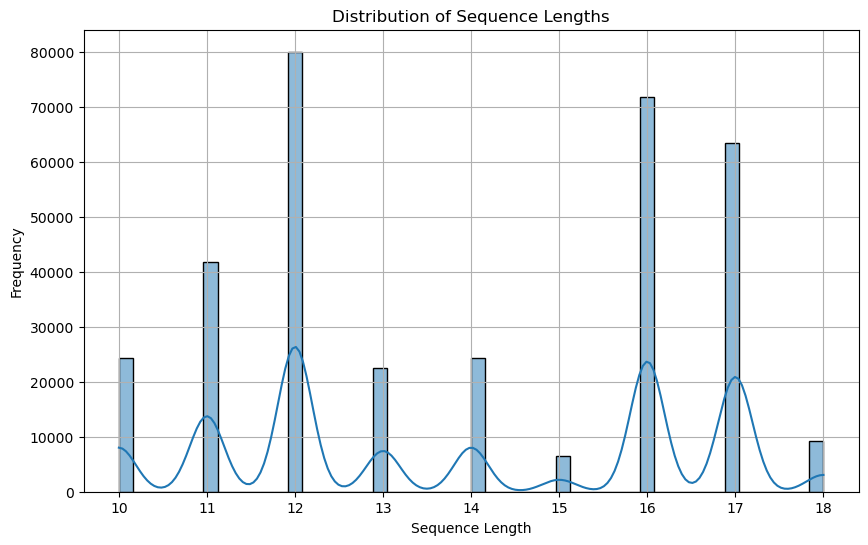

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_seq_len is a DataFrame with a 'seq_length' column
# If df_seq_len is a PySpark DataFrame, convert it to Pandas
df_seq_len_pd = df_seq_len.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_seq_len_pd['seq_length'], bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Padding Sequences to a Fixed Length

###  Step 1: Convert to Sequence Format

In [19]:
from pyspark.sql.functions import collect_list, sort_array, struct

from pyspark.sql.window import Window
from pyspark.sql.functions import collect_list, struct

def make_sequences(df, features):
    # build the 'feature_struct'
    df = df.select(
        "race_id", "horse_id",
        "segment_ordinal",
        struct(*[F.col(f) for f in features]).alias("feature_struct")
    )

    w = (
        Window.partitionBy("race_id", "horse_id")
              .orderBy(F.asc("segment_ordinal"))
              .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    )

    df = df.withColumn(
        "sequence",
        collect_list("feature_struct").over(w)
    ).withColumn(
        "rn",
        row_number().over(
            Window.partitionBy("race_id", "horse_id").orderBy(F.asc("segment_ordinal"))
        )
    )

    # Now, the "last" row for each partition in ascending order is:
    #   rn == count_of_rows_in_that_partition
    # or you can do a second window with "count(*)" and compare.

    # Simpler approach: use a second window or another column to filter just the final row:

    from pyspark.sql.functions import count

    count_window = Window.partitionBy("race_id", "horse_id")
    df = df.withColumn(
        "count_in_part",
        count("*").over(count_window)
    )

    # Now keep only the row where 'rn == count_in_part'
    df = df.filter(F.col("rn") == F.col("count_in_part"))

    df = df.select("race_id", "horse_id", "sequence")
    return df

In [20]:
features = ["length_to_finish", "sectional_time", "running_time",
            "distance_back", "distance_ran", "number_of_strides"]
all_seq = make_sequences(sectionals_df, features)

In [21]:
all_seq.columns

['race_id', 'horse_id', 'sequence']

In [22]:
# Join race_date and relevance back into our sequences.
# We rename the joined relevance column to avoid duplicates.
all_seq = all_seq.join(
    sectionals_df.select("race_id", "horse_id", "race_date", F.col("relevance").alias("joined_relevance"))
        .dropDuplicates(["race_id", "horse_id"]),
    on=["race_id", "horse_id"],
    how="left"
)
# Remove any pre-existing relevance column and rename the joined one.
all_seq = all_seq.drop("relevance").withColumnRenamed("joined_relevance", "relevance")

In [23]:
all_seq.columns

['race_id', 'horse_id', 'sequence', 'race_date', 'relevance']

### Convert to Pandas

In [24]:
all_pd = all_seq.toPandas()

# Sort by race_date to maintain temporal order
all_pd = all_pd.sort_values("race_date").reset_index(drop=True)

In [25]:
print(all_pd.columns)
all_pd.info()

Index(['race_id', 'horse_id', 'sequence', 'race_date', 'relevance'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344182 entries, 0 to 344181
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   race_id    344182 non-null  object 
 1   horse_id   344182 non-null  int32  
 2   sequence   344182 non-null  object 
 3   race_date  344182 non-null  object 
 4   relevance  344182 non-null  float64
dtypes: float64(1), int32(1), object(3)
memory usage: 11.8+ MB


###  ✅ TimeSeriesSplit with Rolling-Window Cross-Validation

In [26]:
# --- Step 1: Prepare Your Data ---
# Assume full_pd is your Pandas DataFrame with the following columns:
#   - "race_date": the date of the race (used for sorting)
#   - "padded_seq": the padded sequence (a list of dicts or arrays, one per sample)
#   - "relevance": the target variable

# First, sort the DataFrame by race_date to ensure temporal order.
full_pd_sorted = all_pd.sort_values("race_date").reset_index(drop=True)

Dataset time range: 2022-01-01 to 2025-03-30
Fold 1: Train indices 0-57366, Test indices 57367-114729
Fold 2: Train indices 0-114729, Test indices 114730-172092
Fold 3: Train indices 0-172092, Test indices 172093-229455
Fold 4: Train indices 0-229455, Test indices 229456-286818
Fold 5: Train indices 0-286818, Test indices 286819-344181


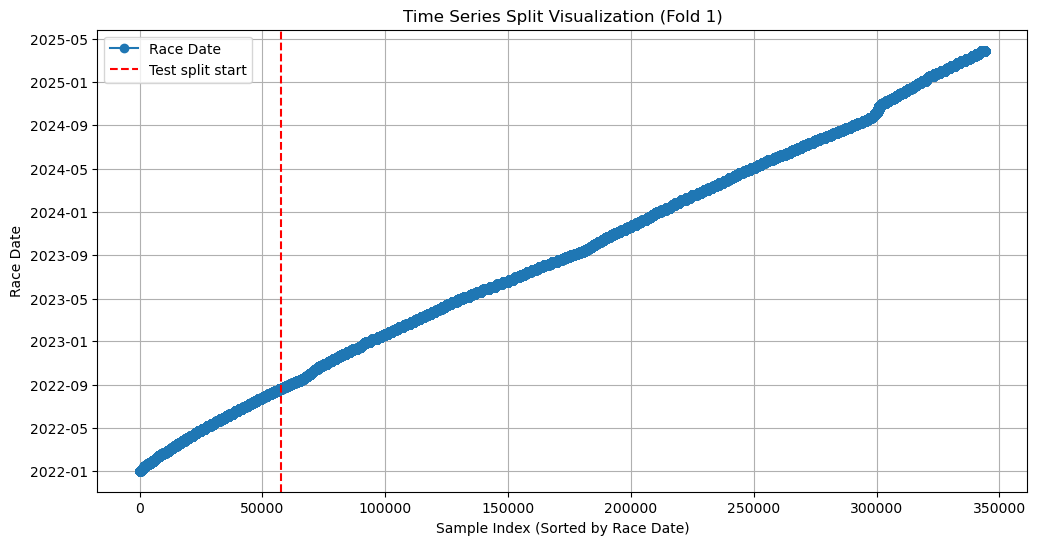

In [27]:
# --- Assume 'all_pd' is your sorted Pandas DataFrame (sorted by race_date) ---
print("Dataset time range:", all_pd["race_date"].min(), "to", all_pd["race_date"].max())

# Create a TimeSeriesSplit object with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Collect indices for each split
splits = list(tscv.split(all_pd))
for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {fold+1}: Train indices {train_idx[0]}-{train_idx[-1]}, Test indices {test_idx[0]}-{test_idx[-1]}")

# --- Plotting one of the splits for visualization ---
# Let's visualize the first split:
train_idx, test_idx = splits[0]

plt.figure(figsize=(12, 6))
# Plot the race_date for each sample as points
plt.plot(all_pd.index, pd.to_datetime(all_pd["race_date"]), marker='o', linestyle='-', label='Race Date')

# Mark the split boundary: first index of the test set
plt.axvline(x=test_idx[0], color='red', linestyle='--', label='Test split start')

plt.xlabel("Sample Index (Sorted by Race Date)")
plt.ylabel("Race Date")
plt.title("Time Series Split Visualization (Fold 1)")
plt.legend()
plt.grid(True)
plt.show()

### Pad Sequences: 

Convert the sequences to a fixed length (e.g., 150) and prepare them for modeling.

In [28]:
def pad_sequence(seq, target_len):
    # Define a default value for each feature
    pad_val = {
        "length_to_finish": 0.0,
        "sectional_time": 0.0,
        "running_time": 0.0,
        "distance_back": 0.0,
        "distance_ran": 0.0,
        "number_of_strides": 0.0
    }
    # Truncate the sequence if it's longer than target_len
    seq = seq[:target_len]
    # Pad with pad_val if it's shorter than target_len
    return seq + [pad_val] * (target_len - len(seq))


def prepare_unified_lstm_dataset(df, target_len=18):
    # Drop duplicates and filter out rows without a relevance score
    df = df.drop_duplicates(subset=["race_id", "horse_id"])
    df = df[df["relevance"].notna()]
    
    # Create a new column 'padded_seq' by applying pad_sequence to the existing 'sequence' column
    df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x, target_len))
    
    # Build a 3D numpy array where each sample's sequence is an array of 7 feature values
    X_all = np.array([
        [
            [
                d["length_to_finish"],
                d["sectional_time"],
                d["running_time"],
                d["distance_back"],
                d["distance_ran"],
                d["number_of_strides"]
            ] for d in seq
        ] for seq in df["padded_seq"]
    ], dtype=np.float32)
    
    # Extract the target variable (relevance) as a 1D array
    y_all = df["relevance"].values.astype(np.float32)
    return X_all, y_all, df




In [29]:
X_all, y_all, full_pd = prepare_unified_lstm_dataset(all_pd, target_len=18)
# Now, X_all should have shape (num_samples, 18, 7) with your new features.
print("X_all shape:", X_all.shape)

X_all shape: (344182, 18, 6)


# Split & Normalize

## Define Helper Functions

In [30]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

# --------------------------------------------
# Outlier Capping (Train/Val versions)
# --------------------------------------------
def cap_outliers_X_train_only(X_train, lower_percentile=1, upper_percentile=99):
    """
    Compute bounds from X_train, apply to X_train.
    Returns: (X_train_capped, (lower_bounds, upper_bounds))
    """
    num_samples, seq_len, num_features = X_train.shape
    X_flat = X_train.reshape(-1, num_features)
    
    lower_bounds = np.percentile(X_flat, lower_percentile, axis=0)
    upper_bounds = np.percentile(X_flat, upper_percentile, axis=0)

    X_flat_capped = np.clip(X_flat, lower_bounds, upper_bounds)
    X_train_capped = X_flat_capped.reshape(num_samples, seq_len, num_features)
    return X_train_capped, (lower_bounds, upper_bounds)

def cap_outliers_X_val(X_val, bounds):
    """
    Apply the train-derived bounds to X_val, no new fit.
    """
    (lower_bounds, upper_bounds) = bounds
    num_samples, seq_len, num_features = X_val.shape
    X_flat = X_val.reshape(-1, num_features)
    
    X_flat_capped = np.clip(X_flat, lower_bounds, upper_bounds)
    return X_flat_capped.reshape(num_samples, seq_len, num_features)

def cap_outliers_y_train_only(y_train, lower_percentile=1, upper_percentile=99):
    """
    Compute bounds from y_train, apply to y_train.
    Returns: (y_train_capped, (lower_bound, upper_bound))
    """
    lower_bound = np.percentile(y_train, lower_percentile)
    upper_bound = np.percentile(y_train, upper_percentile)
    y_train_capped = np.clip(y_train, lower_bound, upper_bound)
    return y_train_capped, (lower_bound, upper_bound)

def cap_outliers_y_val(y_val, y_bounds):
    (lower_bound, upper_bound) = y_bounds
    return np.clip(y_val, lower_bound, upper_bound)

# --------------------------------------------
# PyTorch Dataset
# --------------------------------------------
class HorseRaceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Build a "Train/Val" Prep Function

In [31]:
def build_lstm_dataloaders_time_series(
    X_all, 
    y_all, 
    batch_size=64, 
    n_splits=5,
    save_scalers=True,
    scaler_X_path="training_scalers_gpsscaler_X.pkl",
    scaler_y_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_y.pkl"
):
    """
    1) Do TimeSeriesSplit on (X_all, y_all).
    2) Use last split as train/val.
    3) Cap outliers + scale on train only, apply same transforms to val.
    4) Build DataLoaders for train/val.
    5) Optionally save the scalers.
    """

    # ---------- (A) TimeSeriesSplit ----------
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = list(tscv.split(X_all))
    train_idx, val_idx = splits[-1]  # last split for validation

    X_train_raw, X_val_raw = X_all[train_idx], X_all[val_idx]
    y_train_raw, y_val_raw = y_all[train_idx], y_all[val_idx]

    # ---------- (B) Outlier capping ----------
    # Fit bounds on train, apply to val
    X_train_capped, X_bounds = cap_outliers_X_train_only(X_train_raw)
    X_val_capped = cap_outliers_X_val(X_val_raw, X_bounds)

    y_train_capped, y_bounds = cap_outliers_y_train_only(y_train_raw)
    y_val_capped = cap_outliers_y_val(y_val_raw, y_bounds)

    # ---------- (C) Scaling (train only) ----------
    # Flatten train
    num_train, seq_len, num_features = X_train_capped.shape
    X_train_flat = X_train_capped.reshape(-1, num_features)

    scaler_X = StandardScaler()
    X_train_flat_scaled = scaler_X.fit_transform(X_train_flat)
    X_train_scaled = X_train_flat_scaled.reshape(num_train, seq_len, num_features)

    # Flatten val, transform
    num_val = X_val_capped.shape[0]
    X_val_flat = X_val_capped.reshape(-1, num_features)
    X_val_flat_scaled = scaler_X.transform(X_val_flat)
    X_val_scaled = X_val_flat_scaled.reshape(num_val, seq_len, num_features)

    # Scale y (MinMaxScaler as example)
    scaler_y = MinMaxScaler()
    y_train_2d = y_train_capped.reshape(-1, 1)
    y_train_scaled = scaler_y.fit_transform(y_train_2d).flatten()

    y_val_2d = y_val_capped.reshape(-1, 1)
    y_val_scaled = scaler_y.transform(y_val_2d).flatten()

    # Optional: save scalers to disk for inference
    if save_scalers:
        joblib.dump(scaler_X, scaler_X_path)
        joblib.dump(scaler_y, scaler_y_path)
        print(f"Saved {scaler_X_path} and {scaler_y_path}")

    # ---------- (D) Build PyTorch Datasets & Loaders ----------
    train_dataset = HorseRaceDataset(X_train_scaled, y_train_scaled)
    val_dataset   = HorseRaceDataset(X_val_scaled, y_val_scaled)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, train_dataset, val_dataset, scaler_X, scaler_y

In [32]:
# Suppose X_all, y_all is your complete dataset (raw, unscaled).
train_loader, val_loader, train_dataset, val_dataset, scaler_X, scaler_y = \
    build_lstm_dataloaders_time_series(
        X_all, 
        y_all, 
        batch_size=64, 
        n_splits=5,
        save_scalers=True,  # if you want to save them
        scaler_X_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_X.pkl",
        scaler_y_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_y.pkl"
    )


Saved /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_X.pkl and /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_y.pkl


# 🧠 Basic LSTM Model for Sequence Classification

In [33]:
class HorseRaceLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, out_embed_size=8, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)
        
        # A small linear to produce an 8D embedding:
        self.embed_projector = nn.Linear(hidden_size, out_embed_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        # 'out' shape: (batch, seq_len, hidden_size)
        # 'h_n[-1]' shape: (batch, hidden_size) if num_layers=1

        # We'll take the last time-step for both score + embedding
        last_hidden = out[:, -1, :]  # shape (batch, hidden_size)

        # 1) Final scalar:
        final_score = self.fc(last_hidden)

        # 2) A small embedding (8D):
        embed_vector = self.embed_projector(last_hidden)  
        # shape (batch, out_embed_size)

        return final_score.squeeze(1), embed_vector

In [34]:
# Assuming train_loader is defined and built using normalized X_all and y_all:
for batch_X, batch_y in train_loader:
    print("Batch X stats:")
    print(" - min:", batch_X.min().item())
    print(" - max:", batch_X.max().item())
    print(" - mean:", batch_X.mean().item())
    
    print("Batch y stats:")
    print(" - min:", batch_y.min().item())
    print(" - max:", batch_y.max().item())
    print(" - mean:", batch_y.mean().item())
    break

Batch X stats:
 - min: -1.8327676057815552
 - max: 4.034027099609375
 - mean: -0.031828198581933975
Batch y stats:
 - min: 0.0
 - max: 0.9999999403953552
 - mean: 0.29210445284843445


In [35]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name 0:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 2
Device name 0: NVIDIA RTX A6000


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 🧪 Mini Training Loop

In [37]:
def train_one_epoch(model, dataloader, optimizer, main_loss_fn, device,
                    alpha=0.01, verbose=False):
    """
    Train one epoch with a secondary embedding loss.
    
    Returns the average total loss = main_loss + alpha * embed_loss.
    """
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        
        # model returns (score, embed_vec)
        score, embed_vec = model(X_batch)
        
        # 1) Main MSE loss
        main_loss = main_loss_fn(score, y_batch)
        
        # 2) Secondary objective (example: L2 norm of embed_vec)
        embed_loss = embed_vec.norm(dim=1).mean()  # or something else
        total_loss = main_loss + alpha * embed_loss
        
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
    
    return running_loss / len(dataloader)

In [38]:
# Evaluate function to compute validation loss
def evaluate_lstm(model, dataloader, loss_fn, device, verbose=False):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Unpack the two outputs
            score, embed_vec = model(X_batch)

            # Only compare 'score' with 'y_batch'
            loss = loss_fn(score, y_batch)
            
            total_loss += loss.item()

            if verbose:
                print(f"Batch Loss: {loss.item()}")

    return total_loss / len(dataloader)

In [39]:
def objective(trial):
    # 1) Suggest which optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # 2) Suggest a learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # If using SGD, also pick momentum
    # (You can wrap this in a conditional if you only want momentum for SGD)
    momentum = 0.0
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.0, 0.9, step=0.1)
    
    # 3) Example of other hyperparams
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    num_layers  = trial.suggest_int("num_layers", 1, 2)
    out_embed_size = 8 
    dropout     = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)

    # Print or log the chosen hyperparams for debugging
    print(f"[Trial {trial.number}] "
          f"opt={optimizer_name}, lr={lr:.1e}, momentum={momentum}, "
          f"hidden={hidden_size}, layers={num_layers}, dropout={dropout}")

    # 4) Build a fresh model inside the objective
    model = HorseRaceLSTM(
        input_size=6,
        hidden_size=hidden_size,
        out_embed_size=out_embed_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # 5) Construct the optimizer based on choice
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:  # "SGD"
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # 6) Standard training loop, pruning, etc.
    loss_fn = torch.nn.MSELoss()
    num_epochs = 50
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            loss_fn,
            device,
            alpha=0.01  # or some hyperparam you might tune
        )
        # Evaluate on validation data (only the main objective)
        val_loss = evaluate_lstm(model, val_loader, loss_fn, device)

        print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")

        # Early stopping or pruning logic remains exactly the same:
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stop at epoch {epoch+1}, best_val_loss={best_val_loss:.4f}")
            break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # If we exit the loop (either break or finish all epochs), we return the best loss
    return best_val_loss

In [40]:
# Function to run the Optuna study with SQLite database persistence
def run_optuna(n_trials=75):
    # Create a study with SQLite storage; it will load the study if it already exists
    study = optuna.create_study(
        study_name="sectionals_study_v1",
        storage="sqlite:///optuna_sectional_lstm.db",
        direction="minimize",
        load_if_exists=True
    )
    
    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials)
    
    # Print the best trial's details
    print("Best trial:")
    best_trial = study.best_trial
    print("  Validation Loss:", best_trial.value)
    print("  Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    return study

In [41]:
# # Create (load) a study from the existing SQLite file
# study = optuna.create_study(
#     study_name="sectionals_study_v1",
#     storage="sqlite:///optuna_sectional_lstm.db",
#     direction="minimize",
#     load_if_exists=True
# )
# # Now you can directly access the best trial/params
# best_params = study.best_trial.params
# print("Best params:", best_params)

In [42]:
# Run Optuna tuning
study = run_optuna(n_trials=75)

[I 2025-04-02 08:56:57,968] A new study created in RDB with name: sectionals_study_v1


[Trial 0] opt=Adam, lr=6.3e-03, momentum=0.0, hidden=64, layers=2, dropout=0.2
Epoch 1: Train=0.0391, Val=0.0369
Epoch 2: Train=0.0356, Val=0.0358
Epoch 3: Train=0.0349, Val=0.0355
Epoch 4: Train=0.0346, Val=0.0355
Epoch 5: Train=0.0343, Val=0.0357
Epoch 6: Train=0.0342, Val=0.0357
Epoch 7: Train=0.0341, Val=0.0348
Epoch 8: Train=0.0340, Val=0.0345
Epoch 9: Train=0.0340, Val=0.0348
Epoch 10: Train=0.0338, Val=0.0351
Epoch 11: Train=0.0337, Val=0.0348
Epoch 12: Train=0.0339, Val=0.0346


[I 2025-04-02 08:58:10,524] Trial 0 finished with value: 0.03447791552139963 and parameters: {'optimizer': 'Adam', 'lr': 0.006333891498336159, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.03447791552139963.


Epoch 13: Train=0.0338, Val=0.0345
Early stop at epoch 13, best_val_loss=0.0345
[Trial 1] opt=SGD, lr=9.4e-05, momentum=0.4, hidden=128, layers=1, dropout=0.1
Epoch 1: Train=0.1607, Val=0.1352
Epoch 2: Train=0.1371, Val=0.1330
Epoch 3: Train=0.1347, Val=0.1311
Epoch 4: Train=0.1329, Val=0.1296
Epoch 5: Train=0.1312, Val=0.1283
Epoch 6: Train=0.1298, Val=0.1270
Epoch 7: Train=0.1285, Val=0.1259
Epoch 8: Train=0.1272, Val=0.1248
Epoch 9: Train=0.1260, Val=0.1237
Epoch 10: Train=0.1248, Val=0.1226
Epoch 11: Train=0.1236, Val=0.1215
Epoch 12: Train=0.1224, Val=0.1204
Epoch 13: Train=0.1212, Val=0.1192
Epoch 14: Train=0.1201, Val=0.1180
Epoch 15: Train=0.1189, Val=0.1168
Epoch 16: Train=0.1177, Val=0.1156
Epoch 17: Train=0.1165, Val=0.1143
Epoch 18: Train=0.1153, Val=0.1130
Epoch 19: Train=0.1140, Val=0.1117
Epoch 20: Train=0.1127, Val=0.1104
Epoch 21: Train=0.1114, Val=0.1090
Epoch 22: Train=0.1100, Val=0.1076
Epoch 23: Train=0.1087, Val=0.1062
Epoch 24: Train=0.1073, Val=0.1048
Epoch 25: 

[I 2025-04-02 09:01:56,384] Trial 1 finished with value: 0.07828136937175706 and parameters: {'optimizer': 'SGD', 'lr': 9.38288716606635e-05, 'momentum': 0.4, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.1}. Best is trial 0 with value: 0.03447791552139963.


Epoch 50: Train=0.0787, Val=0.0783
[Trial 2] opt=SGD, lr=2.1e-03, momentum=0.0, hidden=32, layers=2, dropout=0.30000000000000004
Epoch 1: Train=0.1382, Val=0.1297
Epoch 2: Train=0.1298, Val=0.1248
Epoch 3: Train=0.1213, Val=0.1122
Epoch 4: Train=0.1008, Val=0.0843
Epoch 5: Train=0.0748, Val=0.0636
Epoch 6: Train=0.0600, Val=0.0528
Epoch 7: Train=0.0531, Val=0.0481
Epoch 8: Train=0.0500, Val=0.0461
Epoch 9: Train=0.0487, Val=0.0454
Epoch 10: Train=0.0479, Val=0.0447
Epoch 11: Train=0.0471, Val=0.0443
Epoch 12: Train=0.0465, Val=0.0438
Epoch 13: Train=0.0460, Val=0.0433
Epoch 14: Train=0.0456, Val=0.0433
Epoch 15: Train=0.0451, Val=0.0428
Epoch 16: Train=0.0449, Val=0.0425
Epoch 17: Train=0.0444, Val=0.0424
Epoch 18: Train=0.0442, Val=0.0424
Epoch 19: Train=0.0439, Val=0.0421
Epoch 20: Train=0.0437, Val=0.0420
Epoch 21: Train=0.0434, Val=0.0419
Epoch 22: Train=0.0433, Val=0.0416
Epoch 23: Train=0.0430, Val=0.0415
Epoch 24: Train=0.0429, Val=0.0413
Epoch 25: Train=0.0428, Val=0.0412
Epoch

[I 2025-04-02 09:05:50,802] Trial 2 finished with value: 0.03952975204440795 and parameters: {'optimizer': 'SGD', 'lr': 0.0021196640609847184, 'momentum': 0.0, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.03447791552139963.


Epoch 50: Train=0.0406, Val=0.0395
[Trial 3] opt=Adam, lr=2.9e-04, momentum=0.0, hidden=64, layers=1, dropout=0.5
Epoch 1: Train=0.0449, Val=0.0397
Epoch 2: Train=0.0385, Val=0.0386
Epoch 3: Train=0.0377, Val=0.0381
Epoch 4: Train=0.0370, Val=0.0376
Epoch 5: Train=0.0364, Val=0.0369
Epoch 6: Train=0.0359, Val=0.0364
Epoch 7: Train=0.0356, Val=0.0361
Epoch 8: Train=0.0352, Val=0.0358
Epoch 9: Train=0.0349, Val=0.0355
Epoch 10: Train=0.0347, Val=0.0353
Epoch 11: Train=0.0345, Val=0.0351
Epoch 12: Train=0.0343, Val=0.0350
Epoch 13: Train=0.0342, Val=0.0349
Epoch 14: Train=0.0341, Val=0.0348
Epoch 15: Train=0.0340, Val=0.0348
Epoch 16: Train=0.0339, Val=0.0348
Epoch 17: Train=0.0338, Val=0.0347
Epoch 18: Train=0.0337, Val=0.0347
Epoch 19: Train=0.0337, Val=0.0347
Epoch 20: Train=0.0336, Val=0.0346
Epoch 21: Train=0.0336, Val=0.0346
Epoch 22: Train=0.0335, Val=0.0345
Epoch 23: Train=0.0335, Val=0.0345
Epoch 24: Train=0.0334, Val=0.0344
Epoch 25: Train=0.0333, Val=0.0344
Epoch 26: Train=0.03

[I 2025-04-02 09:08:51,970] Trial 3 finished with value: 0.034276629810573465 and parameters: {'optimizer': 'Adam', 'lr': 0.00029333398133608233, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.5}. Best is trial 3 with value: 0.034276629810573465.


Epoch 40: Train=0.0329, Val=0.0343
Early stop at epoch 40, best_val_loss=0.0343
[Trial 4] opt=SGD, lr=3.2e-05, momentum=0.0, hidden=128, layers=2, dropout=0.30000000000000004
Epoch 1: Train=0.2178, Val=0.1763
Epoch 2: Train=0.1692, Val=0.1488
Epoch 3: Train=0.1490, Val=0.1380
Epoch 4: Train=0.1406, Val=0.1340
Epoch 5: Train=0.1371, Val=0.1325
Epoch 6: Train=0.1356, Val=0.1320
Epoch 7: Train=0.1349, Val=0.1319
Epoch 8: Train=0.1346, Val=0.1319
Epoch 9: Train=0.1345, Val=0.1319
Epoch 10: Train=0.1343, Val=0.1319
Epoch 11: Train=0.1342, Val=0.1319
Epoch 12: Train=0.1342, Val=0.1319
Epoch 13: Train=0.1341, Val=0.1318
Epoch 14: Train=0.1340, Val=0.1318
Epoch 15: Train=0.1339, Val=0.1318
Epoch 16: Train=0.1339, Val=0.1317
Epoch 17: Train=0.1338, Val=0.1317
Epoch 18: Train=0.1337, Val=0.1316
Epoch 19: Train=0.1337, Val=0.1316
Epoch 20: Train=0.1336, Val=0.1315
Epoch 21: Train=0.1336, Val=0.1315
Epoch 22: Train=0.1334, Val=0.1314
Epoch 23: Train=0.1334, Val=0.1314
Epoch 24: Train=0.1333, Val=0

[I 2025-04-02 09:12:50,338] Trial 4 finished with value: 0.1300043302070071 and parameters: {'optimizer': 'SGD', 'lr': 3.198471338527564e-05, 'momentum': 0.0, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.30000000000000004}. Best is trial 3 with value: 0.034276629810573465.


Epoch 50: Train=0.1315, Val=0.1300
[Trial 5] opt=Adam, lr=1.4e-03, momentum=0.0, hidden=128, layers=1, dropout=0.1
Epoch 1: Train=0.0404, Val=0.0374
Epoch 2: Train=0.0361, Val=0.0361
Epoch 3: Train=0.0351, Val=0.0354
Epoch 4: Train=0.0345, Val=0.0350
Epoch 5: Train=0.0342, Val=0.0347
Epoch 6: Train=0.0340, Val=0.0345
Epoch 7: Train=0.0338, Val=0.0344
Epoch 8: Train=0.0337, Val=0.0343
Epoch 9: Train=0.0336, Val=0.0342
Epoch 10: Train=0.0335, Val=0.0341
Epoch 11: Train=0.0334, Val=0.0341
Epoch 12: Train=0.0333, Val=0.0341
Epoch 13: Train=0.0332, Val=0.0341
Epoch 14: Train=0.0331, Val=0.0341
Epoch 15: Train=0.0330, Val=0.0340
Epoch 16: Train=0.0329, Val=0.0342
Epoch 17: Train=0.0329, Val=0.0340
Epoch 18: Train=0.0328, Val=0.0341
Epoch 19: Train=0.0328, Val=0.0340
Epoch 20: Train=0.0327, Val=0.0341
Epoch 21: Train=0.0326, Val=0.0341


[I 2025-04-02 09:14:33,311] Trial 5 finished with value: 0.0340079261247513 and parameters: {'optimizer': 'Adam', 'lr': 0.0014380576095999883, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.1}. Best is trial 5 with value: 0.0340079261247513.


Epoch 22: Train=0.0326, Val=0.0341
Early stop at epoch 22, best_val_loss=0.0340
[Trial 6] opt=SGD, lr=3.8e-03, momentum=0.0, hidden=64, layers=1, dropout=0.5


[I 2025-04-02 09:14:37,477] Trial 6 pruned. 


Epoch 1: Train=0.1250, Val=0.1035
[Trial 7] opt=Adam, lr=7.7e-04, momentum=0.0, hidden=32, layers=2, dropout=0.2
Epoch 1: Train=0.0424, Val=0.0387
Epoch 2: Train=0.0378, Val=0.0380
Epoch 3: Train=0.0367, Val=0.0366
Epoch 4: Train=0.0354, Val=0.0353
Epoch 5: Train=0.0348, Val=0.0351
Epoch 6: Train=0.0345, Val=0.0350
Epoch 7: Train=0.0343, Val=0.0349
Epoch 8: Train=0.0341, Val=0.0347
Epoch 9: Train=0.0340, Val=0.0348
Epoch 10: Train=0.0338, Val=0.0345
Epoch 11: Train=0.0337, Val=0.0346
Epoch 12: Train=0.0337, Val=0.0347
Epoch 13: Train=0.0336, Val=0.0349
Epoch 14: Train=0.0336, Val=0.0345


[I 2025-04-02 09:15:54,465] Trial 7 finished with value: 0.034526988937661734 and parameters: {'optimizer': 'Adam', 'lr': 0.0007701257613861188, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2}. Best is trial 5 with value: 0.0340079261247513.


Epoch 15: Train=0.0335, Val=0.0349
Early stop at epoch 15, best_val_loss=0.0345
[Trial 8] opt=SGD, lr=6.5e-04, momentum=0.4, hidden=128, layers=1, dropout=0.0


[I 2025-04-02 09:15:58,853] Trial 8 pruned. 


Epoch 1: Train=0.1334, Val=0.1237
[Trial 9] opt=SGD, lr=2.9e-03, momentum=0.5, hidden=64, layers=2, dropout=0.2


[I 2025-04-02 09:16:03,643] Trial 9 pruned. 


Epoch 1: Train=0.1312, Val=0.1230
[Trial 10] opt=Adam, lr=1.3e-05, momentum=0.0, hidden=128, layers=1, dropout=0.0


[I 2025-04-02 09:16:08,295] Trial 10 pruned. 


Epoch 1: Train=0.1136, Val=0.0770
[Trial 11] opt=Adam, lr=2.1e-04, momentum=0.0, hidden=64, layers=1, dropout=0.5


[I 2025-04-02 09:16:12,840] Trial 11 pruned. 


Epoch 1: Train=0.0478, Val=0.0401
[Trial 12] opt=Adam, lr=8.5e-04, momentum=0.0, hidden=64, layers=1, dropout=0.4
Epoch 1: Train=0.0427, Val=0.0383
Epoch 2: Train=0.0371, Val=0.0369
Epoch 3: Train=0.0358, Val=0.0359
Epoch 4: Train=0.0351, Val=0.0354
Epoch 5: Train=0.0346, Val=0.0350
Epoch 6: Train=0.0343, Val=0.0348
Epoch 7: Train=0.0340, Val=0.0347
Epoch 8: Train=0.0339, Val=0.0345
Epoch 9: Train=0.0337, Val=0.0345
Epoch 10: Train=0.0336, Val=0.0344
Epoch 11: Train=0.0335, Val=0.0343
Epoch 12: Train=0.0334, Val=0.0342
Epoch 13: Train=0.0333, Val=0.0342
Epoch 14: Train=0.0332, Val=0.0342
Epoch 15: Train=0.0332, Val=0.0342
Epoch 16: Train=0.0331, Val=0.0342
Epoch 17: Train=0.0331, Val=0.0342
Epoch 18: Train=0.0330, Val=0.0342


[I 2025-04-02 09:17:39,470] Trial 12 finished with value: 0.0341696735656298 and parameters: {'optimizer': 'Adam', 'lr': 0.0008525805026817898, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.4}. Best is trial 5 with value: 0.0340079261247513.


Epoch 19: Train=0.0330, Val=0.0344
Early stop at epoch 19, best_val_loss=0.0342
[Trial 13] opt=Adam, lr=1.2e-03, momentum=0.0, hidden=128, layers=1, dropout=0.30000000000000004
Epoch 1: Train=0.0411, Val=0.0379
Epoch 2: Train=0.0362, Val=0.0360
Epoch 3: Train=0.0350, Val=0.0353
Epoch 4: Train=0.0345, Val=0.0349
Epoch 5: Train=0.0342, Val=0.0347
Epoch 6: Train=0.0339, Val=0.0345
Epoch 7: Train=0.0338, Val=0.0344
Epoch 8: Train=0.0337, Val=0.0343
Epoch 9: Train=0.0336, Val=0.0344
Epoch 10: Train=0.0334, Val=0.0342
Epoch 11: Train=0.0333, Val=0.0342
Epoch 12: Train=0.0332, Val=0.0342
Epoch 13: Train=0.0332, Val=0.0342
Epoch 14: Train=0.0331, Val=0.0342
Epoch 15: Train=0.0330, Val=0.0342
Epoch 16: Train=0.0330, Val=0.0341
Epoch 17: Train=0.0329, Val=0.0342
Epoch 18: Train=0.0329, Val=0.0342
Epoch 19: Train=0.0328, Val=0.0342
Epoch 20: Train=0.0328, Val=0.0343


[I 2025-04-02 09:19:18,358] Trial 13 finished with value: 0.03413273153126804 and parameters: {'optimizer': 'Adam', 'lr': 0.0011832310902956636, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.30000000000000004}. Best is trial 5 with value: 0.0340079261247513.


Epoch 21: Train=0.0327, Val=0.0342
Early stop at epoch 21, best_val_loss=0.0341
[Trial 14] opt=Adam, lr=8.5e-03, momentum=0.0, hidden=128, layers=1, dropout=0.1
Epoch 1: Train=0.0386, Val=0.0375
Epoch 2: Train=0.0358, Val=0.0359
Epoch 3: Train=0.0349, Val=0.0354
Epoch 4: Train=0.0346, Val=0.0352
Epoch 5: Train=0.0345, Val=0.0356
Epoch 6: Train=0.0343, Val=0.0356


[I 2025-04-02 09:19:52,123] Trial 14 pruned. 


Epoch 7: Train=0.0342, Val=0.0357
[Trial 15] opt=Adam, lr=1.5e-03, momentum=0.0, hidden=128, layers=1, dropout=0.1
Epoch 1: Train=0.0403, Val=0.0378
Epoch 2: Train=0.0360, Val=0.0360
Epoch 3: Train=0.0350, Val=0.0353
Epoch 4: Train=0.0345, Val=0.0352
Epoch 5: Train=0.0342, Val=0.0349
Epoch 6: Train=0.0339, Val=0.0346
Epoch 7: Train=0.0338, Val=0.0346
Epoch 8: Train=0.0336, Val=0.0345
Epoch 9: Train=0.0335, Val=0.0344
Epoch 10: Train=0.0334, Val=0.0343
Epoch 11: Train=0.0333, Val=0.0342
Epoch 12: Train=0.0332, Val=0.0344
Epoch 13: Train=0.0331, Val=0.0344
Epoch 14: Train=0.0331, Val=0.0342
Epoch 15: Train=0.0330, Val=0.0343


[I 2025-04-02 09:21:12,535] Trial 15 finished with value: 0.034215687539474154 and parameters: {'optimizer': 'Adam', 'lr': 0.0015124441411569723, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.1}. Best is trial 5 with value: 0.0340079261247513.


Epoch 16: Train=0.0329, Val=0.0343
Early stop at epoch 16, best_val_loss=0.0342
[Trial 16] opt=Adam, lr=1.8e-03, momentum=0.0, hidden=128, layers=1, dropout=0.4
Epoch 1: Train=0.0401, Val=0.0379
Epoch 2: Train=0.0362, Val=0.0360
Epoch 3: Train=0.0351, Val=0.0352
Epoch 4: Train=0.0345, Val=0.0349
Epoch 5: Train=0.0341, Val=0.0346
Epoch 6: Train=0.0339, Val=0.0345
Epoch 7: Train=0.0337, Val=0.0344
Epoch 8: Train=0.0335, Val=0.0342
Epoch 9: Train=0.0334, Val=0.0342
Epoch 10: Train=0.0333, Val=0.0341
Epoch 11: Train=0.0332, Val=0.0341
Epoch 12: Train=0.0331, Val=0.0340
Epoch 13: Train=0.0330, Val=0.0342
Epoch 14: Train=0.0330, Val=0.0339
Epoch 15: Train=0.0329, Val=0.0339
Epoch 16: Train=0.0329, Val=0.0340
Epoch 17: Train=0.0328, Val=0.0340
Epoch 18: Train=0.0327, Val=0.0341


[I 2025-04-02 09:22:48,252] Trial 16 finished with value: 0.03393615814966203 and parameters: {'optimizer': 'Adam', 'lr': 0.0017818462014286998, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4}. Best is trial 16 with value: 0.03393615814966203.


Epoch 19: Train=0.0326, Val=0.0340
Early stop at epoch 19, best_val_loss=0.0339
[Trial 17] opt=Adam, lr=4.1e-03, momentum=0.0, hidden=32, layers=1, dropout=0.4
Epoch 1: Train=0.0397, Val=0.0372
Epoch 2: Train=0.0362, Val=0.0361
Epoch 3: Train=0.0351, Val=0.0354
Epoch 4: Train=0.0347, Val=0.0351
Epoch 5: Train=0.0344, Val=0.0350
Epoch 6: Train=0.0342, Val=0.0349
Epoch 7: Train=0.0341, Val=0.0347


[I 2025-04-02 09:23:27,294] Trial 17 pruned. 


Epoch 8: Train=0.0340, Val=0.0346
[Trial 18] opt=Adam, lr=9.7e-03, momentum=0.0, hidden=128, layers=1, dropout=0.4
Epoch 1: Train=0.0386, Val=0.0376


[I 2025-04-02 09:23:37,388] Trial 18 pruned. 


Epoch 2: Train=0.0358, Val=0.0370
[Trial 19] opt=Adam, lr=1.9e-03, momentum=0.0, hidden=128, layers=1, dropout=0.1
Epoch 1: Train=0.0396, Val=0.0370
Epoch 2: Train=0.0359, Val=0.0358
Epoch 3: Train=0.0348, Val=0.0351
Epoch 4: Train=0.0343, Val=0.0348
Epoch 5: Train=0.0340, Val=0.0347
Epoch 6: Train=0.0338, Val=0.0345
Epoch 7: Train=0.0337, Val=0.0345
Epoch 8: Train=0.0336, Val=0.0343
Epoch 9: Train=0.0334, Val=0.0344
Epoch 10: Train=0.0334, Val=0.0344
Epoch 11: Train=0.0333, Val=0.0343
Epoch 12: Train=0.0332, Val=0.0343
Epoch 13: Train=0.0332, Val=0.0342
Epoch 14: Train=0.0331, Val=0.0344
Epoch 15: Train=0.0331, Val=0.0342
Epoch 16: Train=0.0330, Val=0.0343
Epoch 17: Train=0.0329, Val=0.0343


[I 2025-04-02 09:25:05,369] Trial 19 finished with value: 0.03416581810716801 and parameters: {'optimizer': 'Adam', 'lr': 0.0019474378984462384, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.1}. Best is trial 16 with value: 0.03393615814966203.


Epoch 18: Train=0.0329, Val=0.0342
Early stop at epoch 18, best_val_loss=0.0342
[Trial 20] opt=Adam, lr=4.8e-04, momentum=0.0, hidden=128, layers=2, dropout=0.4


[I 2025-04-02 09:25:10,867] Trial 20 pruned. 


Epoch 1: Train=0.0423, Val=0.0385
[Trial 21] opt=Adam, lr=1.3e-03, momentum=0.0, hidden=128, layers=1, dropout=0.30000000000000004
Epoch 1: Train=0.0409, Val=0.0377
Epoch 2: Train=0.0364, Val=0.0360
Epoch 3: Train=0.0353, Val=0.0354
Epoch 4: Train=0.0347, Val=0.0351
Epoch 5: Train=0.0343, Val=0.0348
Epoch 6: Train=0.0340, Val=0.0346
Epoch 7: Train=0.0338, Val=0.0345
Epoch 8: Train=0.0336, Val=0.0343
Epoch 9: Train=0.0335, Val=0.0342
Epoch 10: Train=0.0334, Val=0.0341
Epoch 11: Train=0.0333, Val=0.0341
Epoch 12: Train=0.0332, Val=0.0340
Epoch 13: Train=0.0331, Val=0.0340
Epoch 14: Train=0.0330, Val=0.0340
Epoch 15: Train=0.0329, Val=0.0343
Epoch 16: Train=0.0329, Val=0.0341
Epoch 17: Train=0.0328, Val=0.0343
Epoch 18: Train=0.0327, Val=0.0339
Epoch 19: Train=0.0327, Val=0.0340
Epoch 20: Train=0.0326, Val=0.0339
Epoch 21: Train=0.0326, Val=0.0339
Epoch 22: Train=0.0325, Val=0.0341


[I 2025-04-02 09:26:58,528] Trial 21 finished with value: 0.03392532969946447 and parameters: {'optimizer': 'Adam', 'lr': 0.0012512889124544264, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.30000000000000004}. Best is trial 21 with value: 0.03392532969946447.


Epoch 23: Train=0.0325, Val=0.0342
Early stop at epoch 23, best_val_loss=0.0339
[Trial 22] opt=Adam, lr=1.7e-03, momentum=0.0, hidden=128, layers=1, dropout=0.30000000000000004
Epoch 1: Train=0.0399, Val=0.0377
Epoch 2: Train=0.0360, Val=0.0360
Epoch 3: Train=0.0349, Val=0.0353
Epoch 4: Train=0.0344, Val=0.0349
Epoch 5: Train=0.0341, Val=0.0347
Epoch 6: Train=0.0339, Val=0.0346
Epoch 7: Train=0.0337, Val=0.0344
Epoch 8: Train=0.0335, Val=0.0343
Epoch 9: Train=0.0334, Val=0.0343
Epoch 10: Train=0.0333, Val=0.0342
Epoch 11: Train=0.0332, Val=0.0342
Epoch 12: Train=0.0331, Val=0.0343
Epoch 13: Train=0.0330, Val=0.0343
Epoch 14: Train=0.0330, Val=0.0343


[I 2025-04-02 09:28:08,696] Trial 22 finished with value: 0.0341632912452504 and parameters: {'optimizer': 'Adam', 'lr': 0.0016731329830203556, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.30000000000000004}. Best is trial 21 with value: 0.03392532969946447.


Epoch 15: Train=0.0329, Val=0.0343
Early stop at epoch 15, best_val_loss=0.0342
[Trial 23] opt=Adam, lr=9.5e-04, momentum=0.0, hidden=128, layers=1, dropout=0.2


[I 2025-04-02 09:28:13,395] Trial 23 pruned. 


Epoch 1: Train=0.0414, Val=0.0381
[Trial 24] opt=Adam, lr=3.1e-03, momentum=0.0, hidden=128, layers=1, dropout=0.4
Epoch 1: Train=0.0393, Val=0.0370
Epoch 2: Train=0.0358, Val=0.0358
Epoch 3: Train=0.0348, Val=0.0351
Epoch 4: Train=0.0344, Val=0.0349
Epoch 5: Train=0.0341, Val=0.0348


[I 2025-04-02 09:28:41,500] Trial 24 pruned. 


Epoch 6: Train=0.0339, Val=0.0348
[Trial 25] opt=Adam, lr=4.7e-04, momentum=0.0, hidden=32, layers=1, dropout=0.30000000000000004


[I 2025-04-02 09:28:46,072] Trial 25 pruned. 


Epoch 1: Train=0.0462, Val=0.0395
[Trial 26] opt=Adam, lr=1.2e-03, momentum=0.0, hidden=128, layers=1, dropout=0.0


[I 2025-04-02 09:28:50,776] Trial 26 pruned. 


Epoch 1: Train=0.0409, Val=0.0381
[Trial 27] opt=Adam, lr=5.0e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2
Epoch 1: Train=0.0386, Val=0.0368
Epoch 2: Train=0.0354, Val=0.0357
Epoch 3: Train=0.0347, Val=0.0353
Epoch 4: Train=0.0344, Val=0.0352


[I 2025-04-02 09:29:14,181] Trial 27 pruned. 


Epoch 5: Train=0.0342, Val=0.0351
[Trial 28] opt=Adam, lr=2.5e-03, momentum=0.0, hidden=128, layers=1, dropout=0.4
Epoch 1: Train=0.0394, Val=0.0371
Epoch 2: Train=0.0358, Val=0.0357
Epoch 3: Train=0.0348, Val=0.0351
Epoch 4: Train=0.0343, Val=0.0348
Epoch 5: Train=0.0340, Val=0.0347
Epoch 6: Train=0.0338, Val=0.0345
Epoch 7: Train=0.0337, Val=0.0344
Epoch 8: Train=0.0336, Val=0.0344
Epoch 9: Train=0.0335, Val=0.0344
Epoch 10: Train=0.0334, Val=0.0344


[I 2025-04-02 09:30:05,660] Trial 28 pruned. 


Epoch 11: Train=0.0333, Val=0.0344
[Trial 29] opt=Adam, lr=5.8e-03, momentum=0.0, hidden=32, layers=2, dropout=0.30000000000000004
Epoch 1: Train=0.0393, Val=0.0371


[I 2025-04-02 09:30:15,962] Trial 29 pruned. 


Epoch 2: Train=0.0358, Val=0.0363
[Trial 30] opt=Adam, lr=1.8e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2
Epoch 1: Train=0.0399, Val=0.0371
Epoch 2: Train=0.0359, Val=0.0360
Epoch 3: Train=0.0350, Val=0.0354
Epoch 4: Train=0.0345, Val=0.0350
Epoch 5: Train=0.0342, Val=0.0348
Epoch 6: Train=0.0340, Val=0.0347
Epoch 7: Train=0.0338, Val=0.0345
Epoch 8: Train=0.0336, Val=0.0344
Epoch 9: Train=0.0335, Val=0.0342
Epoch 10: Train=0.0334, Val=0.0342
Epoch 11: Train=0.0333, Val=0.0341
Epoch 12: Train=0.0332, Val=0.0341
Epoch 13: Train=0.0332, Val=0.0342
Epoch 14: Train=0.0331, Val=0.0341
Epoch 15: Train=0.0330, Val=0.0341


[I 2025-04-02 09:31:32,813] Trial 30 finished with value: 0.034102217897506996 and parameters: {'optimizer': 'Adam', 'lr': 0.0017693682221243865, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2}. Best is trial 21 with value: 0.03392532969946447.


Epoch 16: Train=0.0329, Val=0.0342
Early stop at epoch 16, best_val_loss=0.0341
[Trial 31] opt=Adam, lr=1.4e-03, momentum=0.0, hidden=128, layers=1, dropout=0.1
Epoch 1: Train=0.0400, Val=0.0371
Epoch 2: Train=0.0361, Val=0.0360


[I 2025-04-02 09:31:47,684] Trial 31 pruned. 


Epoch 3: Train=0.0352, Val=0.0355
[Trial 32] opt=Adam, lr=2.3e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2
Epoch 1: Train=0.0394, Val=0.0372
Epoch 2: Train=0.0358, Val=0.0359
Epoch 3: Train=0.0349, Val=0.0352
Epoch 4: Train=0.0344, Val=0.0348
Epoch 5: Train=0.0341, Val=0.0347
Epoch 6: Train=0.0339, Val=0.0346
Epoch 7: Train=0.0337, Val=0.0345
Epoch 8: Train=0.0336, Val=0.0344
Epoch 9: Train=0.0335, Val=0.0343
Epoch 10: Train=0.0334, Val=0.0342
Epoch 11: Train=0.0333, Val=0.0342
Epoch 12: Train=0.0332, Val=0.0341
Epoch 13: Train=0.0332, Val=0.0340
Epoch 14: Train=0.0331, Val=0.0340
Epoch 15: Train=0.0331, Val=0.0339
Epoch 16: Train=0.0330, Val=0.0341
Epoch 17: Train=0.0330, Val=0.0340
Epoch 18: Train=0.0329, Val=0.0340
Epoch 19: Train=0.0328, Val=0.0340


[I 2025-04-02 09:33:22,563] Trial 32 finished with value: 0.03390545552282894 and parameters: {'optimizer': 'Adam', 'lr': 0.002255870466913282, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2}. Best is trial 32 with value: 0.03390545552282894.


Epoch 20: Train=0.0328, Val=0.0339
Early stop at epoch 20, best_val_loss=0.0339
[Trial 33] opt=Adam, lr=2.6e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2
Epoch 1: Train=0.0393, Val=0.0369
Epoch 2: Train=0.0357, Val=0.0357
Epoch 3: Train=0.0348, Val=0.0351
Epoch 4: Train=0.0344, Val=0.0349
Epoch 5: Train=0.0341, Val=0.0348
Epoch 6: Train=0.0339, Val=0.0346
Epoch 7: Train=0.0338, Val=0.0345
Epoch 8: Train=0.0337, Val=0.0344
Epoch 9: Train=0.0336, Val=0.0344
Epoch 10: Train=0.0335, Val=0.0342
Epoch 11: Train=0.0334, Val=0.0342
Epoch 12: Train=0.0333, Val=0.0343
Epoch 13: Train=0.0333, Val=0.0344
Epoch 14: Train=0.0332, Val=0.0342
Epoch 15: Train=0.0332, Val=0.0342
Epoch 16: Train=0.0331, Val=0.0342
Epoch 17: Train=0.0331, Val=0.0341
Epoch 18: Train=0.0330, Val=0.0341
Epoch 19: Train=0.0330, Val=0.0342
Epoch 20: Train=0.0329, Val=0.0343
Epoch 21: Train=0.0329, Val=0.0343


[I 2025-04-02 09:35:05,634] Trial 33 finished with value: 0.03410246722512321 and parameters: {'optimizer': 'Adam', 'lr': 0.0026478951090959384, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.2}. Best is trial 32 with value: 0.03390545552282894.


Epoch 22: Train=0.0328, Val=0.0343
Early stop at epoch 22, best_val_loss=0.0341
[Trial 34] opt=SGD, lr=5.3e-03, momentum=0.9, hidden=128, layers=1, dropout=0.1


[I 2025-04-02 09:35:09,991] Trial 34 pruned. 


Epoch 1: Train=0.0555, Val=0.0431
[Trial 35] opt=Adam, lr=2.2e-03, momentum=0.0, hidden=128, layers=1, dropout=0.30000000000000004
Epoch 1: Train=0.0400, Val=0.0375


[I 2025-04-02 09:35:19,381] Trial 35 pruned. 


Epoch 2: Train=0.0360, Val=0.0361
[Trial 36] opt=SGD, lr=1.1e-03, momentum=0.9, hidden=128, layers=1, dropout=0.1


[I 2025-04-02 09:35:23,740] Trial 36 pruned. 


Epoch 1: Train=0.0980, Val=0.0586
[Trial 37] opt=Adam, lr=3.5e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0402, Val=0.0375


[I 2025-04-02 09:35:34,044] Trial 37 pruned. 


Epoch 2: Train=0.0368, Val=0.0363
[Trial 38] opt=SGD, lr=6.5e-04, momentum=0.6000000000000001, hidden=64, layers=1, dropout=0.30000000000000004


[I 2025-04-02 09:35:38,308] Trial 38 pruned. 


Epoch 1: Train=0.1286, Val=0.1194
[Trial 39] opt=Adam, lr=2.5e-04, momentum=0.0, hidden=128, layers=1, dropout=0.2


[I 2025-04-02 09:35:43,004] Trial 39 pruned. 


Epoch 1: Train=0.0455, Val=0.0391
[Trial 40] opt=SGD, lr=2.1e-03, momentum=0.7000000000000001, hidden=128, layers=2, dropout=0.0


[I 2025-04-02 09:35:47,914] Trial 40 pruned. 


Epoch 1: Train=0.1247, Val=0.1051
[Trial 41] opt=Adam, lr=1.7e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2


[I 2025-04-02 09:35:52,611] Trial 41 pruned. 


Epoch 1: Train=0.0402, Val=0.0379
[Trial 42] opt=Adam, lr=3.7e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2
Epoch 1: Train=0.0391, Val=0.0372
Epoch 2: Train=0.0357, Val=0.0359
Epoch 3: Train=0.0348, Val=0.0353
Epoch 4: Train=0.0344, Val=0.0350


[I 2025-04-02 09:36:16,019] Trial 42 pruned. 


Epoch 5: Train=0.0342, Val=0.0349
[Trial 43] opt=Adam, lr=1.2e-03, momentum=0.0, hidden=128, layers=1, dropout=0.2


[I 2025-04-02 09:36:20,732] Trial 43 pruned. 


Epoch 1: Train=0.0410, Val=0.0380
[Trial 44] opt=Adam, lr=2.0e-03, momentum=0.0, hidden=64, layers=1, dropout=0.30000000000000004


[W 2025-04-02 09:36:22,566] Trial 44 failed with parameters: {'optimizer': 'Adam', 'lr': 0.0020478211375839807, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.30000000000000004} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1271716/2183669614.py", line 48, in objective
    train_loss = train_one_epoch(
  File "/tmp/ipykernel_1271716/628068839.py", line 27, in train_one_epoch
    total_loss.backward()
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/site-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/home/exx/anaconda3/envs/mamba_env/e

KeyboardInterrupt: 

Best trial:

  Validation Loss: 0.034659150357237045

    Best hyperparameters:
    
    dropout: 0.5
    
    hidden_size: 32
    
    lr: 0.004911585567541528
    
    num_layers: 2
    
    optimizer: Adam

## Build the final model


In [44]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

NameError: name 'study' is not defined

In [ ]:
from torch.utils.data import ConcatDataset, DataLoader

def build_combined_loader(train_dataset, val_dataset, batch_size=64, shuffle=True, pin_memory=True):
    """
    Concatenate train_dataset and val_dataset into one bigger dataset,
    then build a DataLoader from it.
    
    Args:
        train_dataset (Dataset): Your training dataset.
        val_dataset   (Dataset): Your validation dataset.
        batch_size    (int):     Batch size for the DataLoader.
        shuffle       (bool):    Whether to shuffle the combined dataset.
        pin_memory    (bool):    If True, DataLoader will copy Tensors into 
                                 pinned memory before returning them (speeds GPU transfers).

    Returns:
        DataLoader: a DataLoader that yields batches from the combined dataset.
    """
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory
    )
    return combined_loader

In [ ]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params

#final_model = HorseRaceLSTM(input_size=6b, hidden_size=128, num_layers=1, dropout=0.2)
# Best params: {'dropout': 0.2, 'hidden_size': 128, 'lr': 7.755250942257958e-05, 
# 'num_layers': 1, 'optimizer': 'Adam'}

# Instantiate the final model with the best parameters
final_model = HorseRaceLSTM(
    input_size=6,
    hidden_size=best_params["hidden_size"],
    out_embed_size=8,  
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
).to(device)

# Use the best learning rate
#optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])

# optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0016580606371171412)
loss_fn = torch.nn.MSELoss()

# (Optional) Combine train and validation data if desired, or use train_loader for further training.
# For this example, we continue training on the train_loader.
num_epochs_final = 50  # Adjust epochs as needed

# Example: combine train + val if you want maximum data usage
combined_loader = build_combined_loader(train_dataset, val_dataset, batch_size=64)

for epoch in range(num_epochs_final):
    train_loss = train_one_epoch(final_model, combined_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch+1} - Combined Train Loss = {train_loss:.4f}")
    

# Update Horse Sectionals Table

In [ ]:
import torch
import numpy as np
from pyspark.sql import Row

# We'll assume final_model(...) => (raw_score, embed_vec)
# raw_score: shape (batch,), embed_vec: shape (batch, 8)
projected_scores = {}
projected_embeds = {}

final_model.eval()
with torch.no_grad():
    for i, row in all_pd.iterrows():
        x = torch.tensor(X_all[i], dtype=torch.float32).unsqueeze(0).to(device)
        
        # model returns two things now:
        raw_score_tensor, embed_vec_tensor = final_model(x)
        
        raw_score = raw_score_tensor.item()                      # single float
        embed_arr = embed_vec_tensor.cpu().numpy().flatten()     # shape (8,)
        
        horse_id = row["horse_id"]
        projected_scores[horse_id] = raw_score
        projected_embeds[horse_id] = embed_arr

# 2) Min–max scale the raw scores to [0..1000]
scores_array = np.array(list(projected_scores.values()))
min_s = scores_array.min()
max_s = scores_array.max()

range_s = max_s - min_s if max_s > min_s else 1e-9

scaled_scores = {}
for horse_id, raw_score in projected_scores.items():
    normalized = (raw_score - min_s) / range_s   # [0..1]
    scaled_val = normalized * 1000.0            # [0..1000]
    scaled_scores[horse_id] = scaled_val

# 3) Build a Spark DataFrame with columns:
#  [horse_id, score, dim1, dim2, ..., dim8]

rows = []
for horse_id, sc in scaled_scores.items():
    emb = projected_embeds[horse_id]
    # Make a dict for each row
    row_dict = {
        "horse_id": int(horse_id),
        "score": float(sc),
    }
    # Add each dimension of the embedding as a separate column
    for i, val in enumerate(emb):
        row_dict[f"dim{i+1}"] = float(val)

    rows.append(Row(**row_dict))

df_scores = spark.createDataFrame(rows)

# 4) Write to DB via Spark JDBC
staging_table = "horse_sectionals_lstm"

(
    df_scores.write
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", staging_table)
    .option("user", jdbc_properties["user"])
    .option("driver", jdbc_properties["driver"])
    .mode("overwrite")  # or "append"
    .save()
)

# Sectionals Disribution of Scores

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_scores is your Spark DataFrame
df_scores_pandas = df_scores.select("score").toPandas()

# Plot the distribution of scores with more bins
plt.figure(figsize=(10, 6))
sns.histplot(df_scores_pandas["score"], bins=100, kde=True)  # Increase the number of bins to 100
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Evaluate Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # The model returns (score, embed_vec)
            score_tensor, embed_vec = model(X_batch)
            
            # Convert the score to CPU numpy
            all_preds.extend(score_tensor.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

In [ ]:
evaluate_regression(final_model, val_loader, device)

# Save Model

In [ ]:
torch.save(final_model.state_dict(), "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250325.pt")

# Load Model

In [ ]:
model = HorseRaceLSTM(input_size=3, hidden_size=64, num_layers=1, dropout=0.2)
model.load_state_dict(torch.load("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250325"))
model.to(device)
model.eval()

alter table horse_scores_lstm_gps
add CONSTRAINT horse_gps_lstm_id_key UNIQUE (horse_id);

CREATE INDEX idx_horse_gps_lstm ON public.horse_scores_lstm_gps USING btree (horse_id);
